In [42]:
!pip install librosa
import torch
import torchvision
import librosa
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import io
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch import optim, nn
from tqdm.notebook import tqdm
from PIL import Image, ImageOps
import re
import json
import torchaudio

# Learning how to turn audios into images

In [102]:
files.upload()
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d toponowicz/spoken-language-identification

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 65 Apr 20 18:43 kaggle.json
100% 14.9G/14.9G [12:46<00:00, 24.0MB/s]
100% 14.9G/14.9G [12:46<00:00, 20.9MB/s]


In [103]:
!unzip spoken-language-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/es_m_b53274d3ef7996a22d6ec929c1869804.fragment16.pitch5.flac  
  inflating: train/train/es_m_b53274d3ef7996a22d6ec929c1869804.fragment16.pitch6.flac  
  inflating: train/train/es_m_b53274d3ef7996a22d6ec929c1869804.fragment16.pitch7.flac  
  inflating: train/train/es_m_b53274d3ef7996a22d6ec929c1869804.fragment16.pitch8.flac  
  inflating: train/train/es_m_b53274d3ef7996a22d6ec929c1869804.fragment16.speed1.flac  
  inflating: train/train/es_m_b53274d3ef7996a22d6ec929c1869804.fragment16.speed2.flac  
  inflating: train/train/es_m_b53274d3ef7996a22d6ec929c1869804.fragment16.speed3.flac  
  inflating: train/train/es_m_b53274d3ef7996a22d6ec929c1869804.fragment16.speed4.flac  
  inflating: train/train/es_m_b53274d3ef7996a22d6ec929c1869804.fragment16.speed5.flac  
  inflating: train/train/es_m_b53274d3ef7996a22d6ec929c1869804.fragment16.speed6.flac  
  inflating: train/train/es_m_b53274d3ef7996a22d6ec929c1869804.fragme

In [104]:
audio_files = !find train/train -name "*.flac"

train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise1.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise10.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise11.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise12.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise2.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise3.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise4.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise5.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise6.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise7.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise8.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise9.flac
train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.pitch1.f

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [105]:
# Randomly select 3 audio files.
sampled_audio_files = random.sample(audio_files, 3)

# Print the paths of the sampled audio files.
for audio_file in sampled_audio_files:
    print(audio_file)

train/train/en_m_17b5d4995191976232356345dfbb82cb.fragment10.speed8.flac
train/train/es_f_56ef0bde6c92a0100da23cdd39a8a112.fragment9.noise4.flac
train/train/es_m_406bb0dc71a22051d900bc55cdfad59e.fragment12.speed6.flac




```
(language)_(gender)_(recording ID).fragment(index)[.(transformation)(index)].flac
```



In [106]:
# TODO get lables from file path
type(audio_file)

str

In [107]:
array, sampling_rate = librosa.load(audio_file)

type(sampling_rate)

int

## Waveform

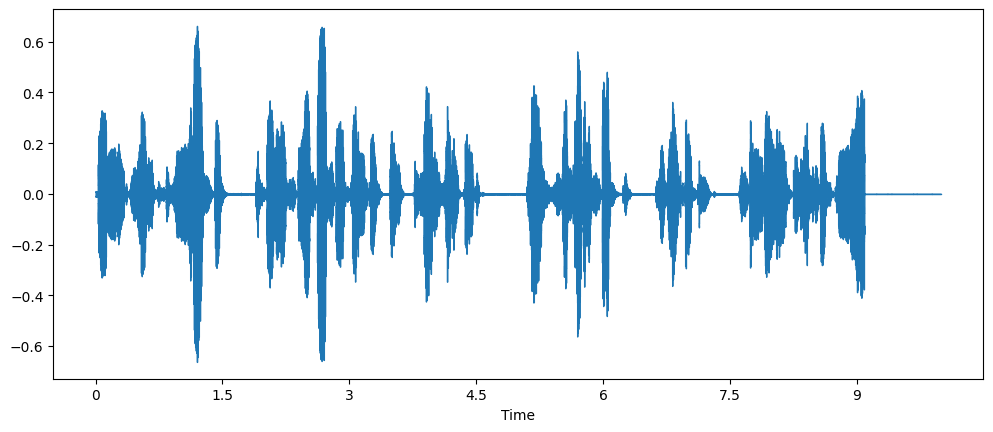

In [108]:
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

## Spectogram

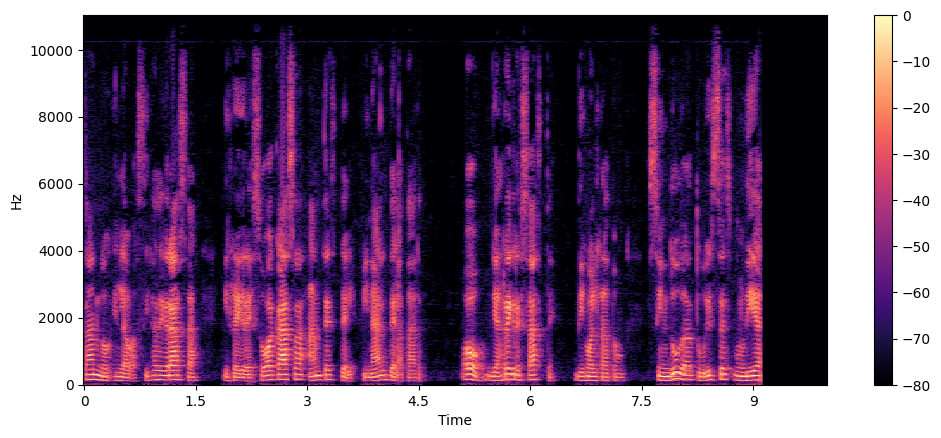

In [109]:
D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

## Frequency spectrum

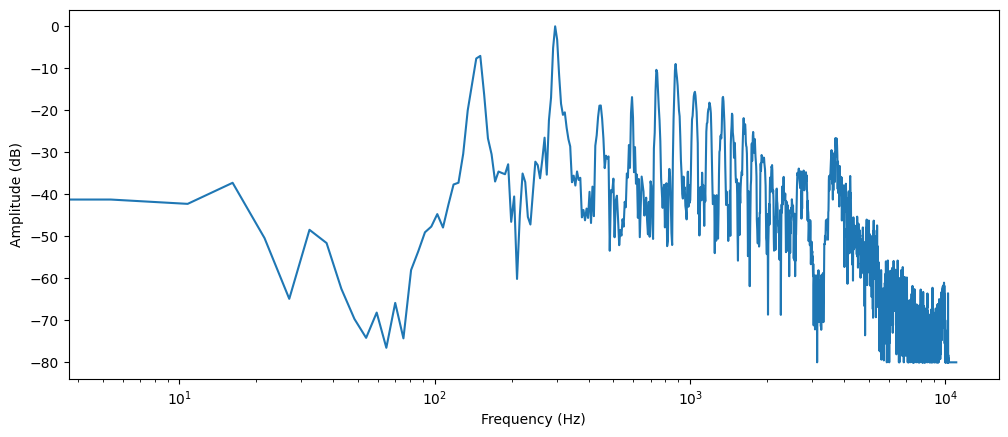

In [110]:
dft_input = array[:4096]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

## Mel spectrogram

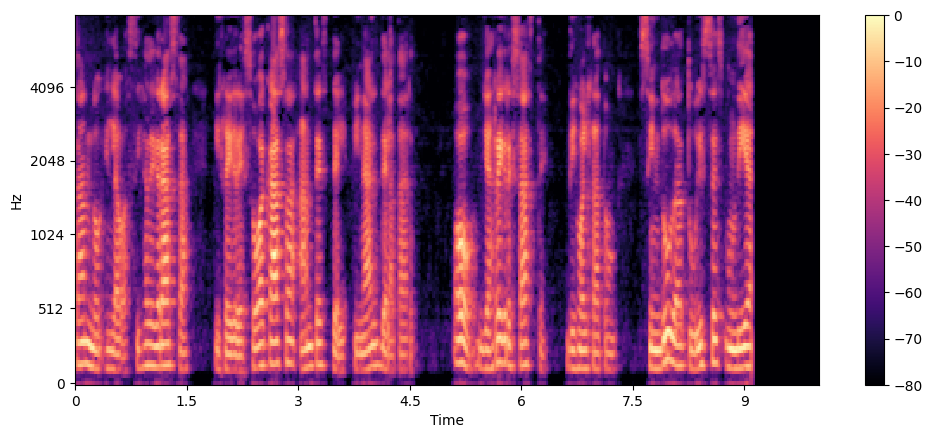

In [111]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

In [112]:
type(S_dB)

numpy.ndarray

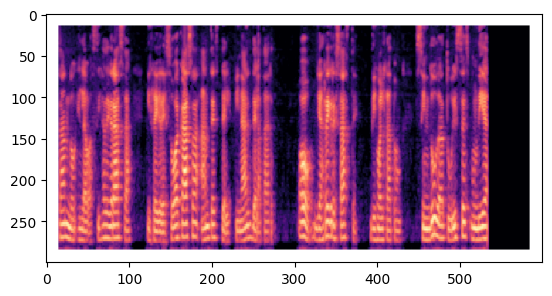

In [113]:
def audio_to_image(audio_path):
    array, sampling_rate = librosa.load(audio_path)

    # Directly pass the result of melspectrogram and power_to_db to specshow
    plt.figure(figsize=(6, 3))
    librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000), ref=np.max),
                             x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
    plt.axis('off')
    plt.tight_layout()

    # Convert the figure to an RGBA array
    fig = plt.gcf()
    fig.canvas.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())

    # Convert RGBA to RGB
    image_rgb = image[:, :, :3]

    plt.close(fig)  # Close the figure to release resources

    # print(image_rgb.shape)

    return image_rgb

plt.imshow(audio_to_image(audio_file))

# Spoken Language Dataset Class

torch.Size([201, 1103, 3])


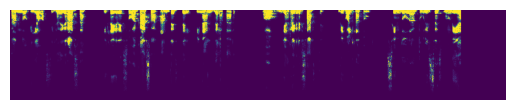

In [114]:
import torchaudio
import torch
import matplotlib.pyplot as plt

waveform, sample_rate = torchaudio.load(audio_file)
spectrogram_transform = torchaudio.transforms.Spectrogram()
spectrogram = spectrogram_transform(waveform)
spectrogram_colored = plt.cm.viridis(spectrogram)
spectrogram_colored = (spectrogram_colored - spectrogram_colored.min()) / (spectrogram_colored.max() - spectrogram_colored.min())
spectrogram_tensor = torch.tensor(spectrogram_colored.squeeze(0))[:,:,:3]

print(spectrogram_tensor.shape)
plt.imshow(spectrogram_tensor)
plt.axis('off')
plt.show()


In [ ]:
class AudioDataset(Dataset):
    def __init__(self, path, train=True, image_type='mel'):
        super(AudioDataset, self).__init__()
        self.image_type = image_type
        self.size = 224
        self.path = path
        self.audio_files = [f for f in os.listdir(os.path.join(path)) if f.endswith('.flac')]
        self.transform = transforms.Compose([
            transforms.Resize((self.size, self.size)),
            ])

        if train:
            with open(os.path.join('train_labels.json'), 'r') as f:
                self.labels = json.load(f)
        else:
            with open(os.path.join('test_labels.json'), 'r') as f:
                self.labels = json.load(f)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        audio_path = os.path.join(self.path, audio_file)
        label = self.labels.get(audio_file)

        waveform, sample_rate = torchaudio.load(audio_path)

        if self.image_type == 'mel':
            spectrogram = torchaudio.transforms.MelSpectrogram(n_fft=512)(waveform)
        else:
            spectrogram = torchaudio.transforms.Spectrogram(n_fft=512)(waveform)

        # grayscale to color
        spectrogram_colored = plt.cm.viridis(spectrogram)
        spectrogram_tensor = torch.Tensor(spectrogram_colored.squeeze(0))[:,:,:3].permute(2,0,1)

        return spectrogram_tensor, label

    def __len__(self):
        return len(self.audio_files)

## Parsing the labels into json documents

In [117]:
def parse_labels(train=True):
    if train:
        directory_path = 'train/train'
        labels_file = 'train_labels.json'
    else:
        directory_path = 'test/test'
        labels_file = 'test_labels.json'

    mapping_file = 'label_mapping.json'

    language_dict = {}
    for file in os.listdir(directory_path):
        parts = file.split('_')
        language = parts[0]
        language_dict[file] = language

    label_mapping = {lang: idx for idx, lang in enumerate(sorted(set(language_dict.values())))}

    language_dict = {file: label_mapping[lang] for file, lang in language_dict.items()}

    if not os.path.exists(labels_file):
        with open(labels_file, 'w') as f:
            json.dump(language_dict, f)

    if not os.path.exists(mapping_file):
        with open(mapping_file, 'w') as f:
            json.dump(label_mapping, f)

parse_labels(True)
parse_labels(False)

In [118]:
with open('train_labels.json', 'r') as f:
    labels = json.load(f)
    print(min(labels.values()))

0


## Testing grabbing a batch of images

torch.Size([4, 3, 128, 862])
tensor([1, 2, 1, 2])


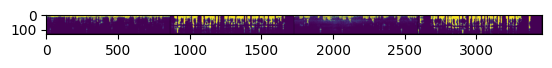

In [ ]:
batch_size = 4
train_path = 'train/train'
test_path = 'test/test'

train_dataset = AudioDataset(train_path, train=True)
test_dataset = AudioDataset(test_path, train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))

print(labels)

# CNN Architecture based on ResNet

In [ ]:
from torchvision.models import resnet18

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.model = resnet18(weights='ResNet18_Weights.DEFAULT')

        self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=num_classes)
        self.model.fc.requires_grad = True

    def forward(self, x):
        return self.model(x)

Testing 1 pass

In [ ]:
model = CNN(num_classes=3)

x, y = next(dataiter)

In [ ]:
x.shape

torch.Size([4, 3, 128, 862])

In [ ]:
model(x)

tensor([[ 0.0127, -0.4490,  0.6262],
        [-0.3402, -0.7985,  1.3424],
        [-0.0222,  0.1835,  0.9137],
        [-0.2985, -0.0326,  0.8830]], grad_fn=<AddmmBackward0>)

In [154]:
def accuracy(y_hat, y_truth):
    """Gets average accuracy of a vector of predictions"""

    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc

In [155]:
def train(model, train_loader, objective, optimizer, epochs, device):

    pbar = tqdm(total=len(train_loader) * epochs, leave=True)

    train_losses = []
    train_accs = []

    cnt = 1
    for epoch in range(epochs):

        for x, y_truth in train_loader:

            x, y_truth = x.to(device), y_truth.to(device)

            optimizer.zero_grad()

            y_hat = model(x)
            train_loss = objective(y_hat, y_truth)
            train_acc = accuracy(y_hat, y_truth)

            train_loss.backward()
            optimizer.step()

            train_accs.append(train_acc.cpu().item())
            train_losses.append(train_loss.cpu().item())

            pbar.set_description('train loss:{:.4f}, train accuracy:{:.4f}.'.format(train_loss.item(), train_acc.item()))

            pbar.update(1)
            cnt += 1

    pbar.close()

    plt.subplot(121)
    plt.plot(np.arange(len(train_accs)), train_accs, label='Train Accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
    plt.legend()
    plt.show()

    index = (len(train_loader) * epochs) - 50

    print(f'Train Accuracy: {np.mean(train_accs[index:])}')
    print(f'Train Loss: {np.mean(train_losses[index:])}')

    return train_losses, train_accs, model

In [156]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

def evaluate(model, test_loader, objective, device):
    val_losses = 0
    val_accs = 0
    batches = 0
    predictions = []
    ground_truth = []
    all_probs = []
    model.eval()

    with torch.no_grad():
        for x, y_truth in test_loader:

            batches += 1

            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)
            val_loss = objective(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)

            val_losses += val_loss.item()
            val_accs += val_acc

            # confusion matrix stuff
            predictions.extend(torch.argmax(y_hat, dim=1).cpu().numpy())
            ground_truth.extend(y_truth.cpu().numpy())

            # softmax probabilities
            probs = torch.softmax(y_hat, dim=1)
            all_probs.extend(probs.cpu().numpy())

    confusion_matrix_ = confusion_matrix(ground_truth, predictions)

    model.train()

    test_loss, test_acc = val_losses/batches, val_accs/batches

    print(f'Test Accuracy: {test_acc}')
    print(f'Test Loss: {test_loss}')

    plt.imshow(confusion_matrix_, cmap='gray', interpolation='none')
    plt.show()

    # Plot ROC curve
    all_probs = np.array(all_probs)
    num_classes = all_probs.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(ground_truth, all_probs[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

In [161]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [126]:
class SubsetSampler(torch.utils.data.Sampler):
    def __init__(self, subset_indices):
        self.subset_indices = subset_indices

    def __iter__(self):
        return iter(self.subset_indices)

    def __len__(self):
        return len(self.subset_indices)

  0%|          | 0/2284 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


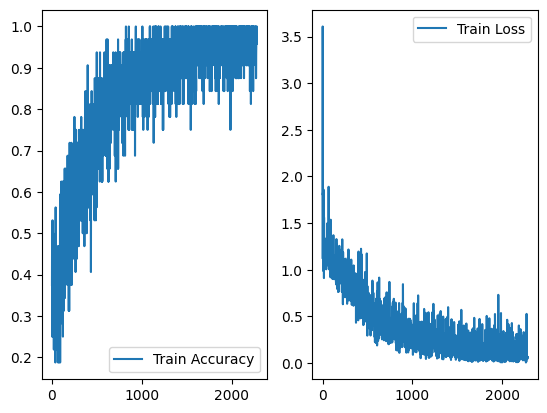

Train Accuracy: 0.9635416674613952
Train Loss: 0.09489699809812009


In [ ]:
subset_percentage = 1  # Select 50% of the training dataset randomly
epochs = 1
lr = 0.01
num_classes = 3 # engish, spanish, german
batch_size = 32
device = torch.device('cuda:0')

train_path = 'train/train'
test_path = 'test/test'

train_dataset = AudioDataset(train_path, train=True)
test_dataset = AudioDataset(test_path, train=False)

subset_indices = np.random.choice(len(train_dataset), int(len(train_dataset) * subset_percentage), replace=False)
subset_sampler = SubsetSampler(subset_indices)

train_loader = DataLoader(train_dataset,
                          sampler=subset_sampler,
                          num_workers=2,
                          batch_size=batch_size,
                          pin_memory=True)
test_loader = DataLoader(test_dataset,
                            shuffle=True,
                            num_workers=2,
                            batch_size=batch_size,
                            pin_memory=True)

model = CNN(num_classes).cuda()

objective = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, train_accs, model = train(model, train_loader, objective, optimizer, epochs, device)

Test Accuracy: 0.6373424530029297
Test Loss: 2.176744482096504


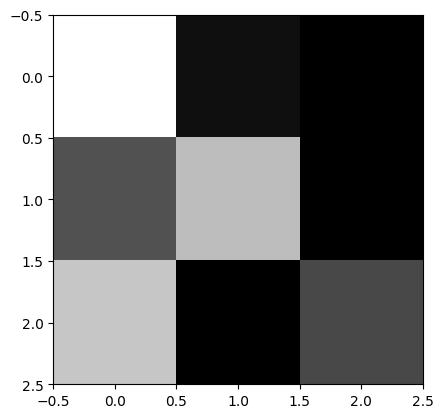

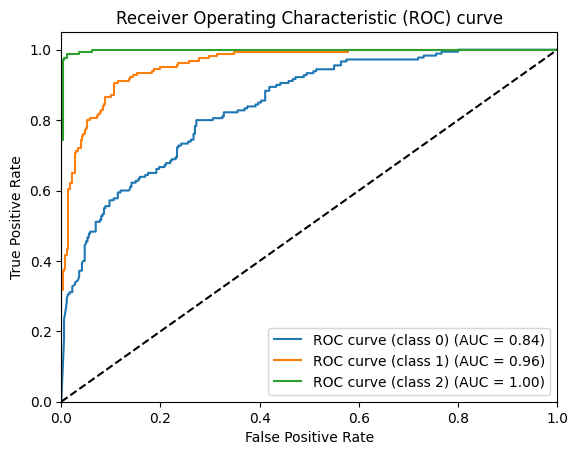

In [ ]:
evaluate(model, test_loader, objective, device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.eval()
model_save_path = '/content/drive/MyDrive/cnn-audio-class.pt'
torch.save(model.state_dict(), model_save_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/cnn-audio-class.pt .
model = CNN(num_classes=3).cuda()
model.load_state_dict(torch.load('cnn-audio-class.pt'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

# Learning about Transformer Architectures for Audio classification




In a previous section you’ve seen that CTC is an efficient technique for performing automatic speech recognition using an encoder-only transformer. Such CTC models already are classifiers, predicting probabilities for class labels from a tokenizer vocabulary. We can take a CTC model and turn it into a general-purpose audio classifier by changing the labels and training it with a regular cross-entropy loss function instead of the special CTC loss.



### Audio Classification

__ResNet__
- Can use a normal CNN like ResNet and get good predictions (input is spectogram)

__Audio Spectogram Transformer__
- Can use a ViT (no CNN) or AST to get even better results using a CNN and transformer encoder on top (input is specogram)
(https://arxiv.org/pdf/2104.01778.pdf)

__Whisper__
(https://huggingface.co/openai/whisper-medium)
- For ASR and speech translation.
- Transformer based encoder-decoder: encodes info from input image to embedding for decoder to decode into text (sequence-to-sequence model)
- Input is spectograms (WhisperProcessor) (80, 3000) but can be designed to take in wave forms instead


Wav2Vec2ForSequenceClassification

- since it's just a classifier it doens't need a transformer decoder... (future project for speech recognition)

Testing Huggingface tutorial

In [1]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-om7ckt7r
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-om7ckt7r
  Resolved https://github.com/huggingface/transformers to commit 8c12690cecbb97e187861e386f7a0ac790e4236c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install datasets

  Using cached datasets-2.19.0-py3-none-any.whl (542 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


# FLEURS Dataset

In [3]:
from datasets import load_dataset
from transformers import pipeline

fleurs = load_dataset("google/fleurs", "all", split="validation", streaming=True)
sample = next(iter(fleurs))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for google/fleurs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google/fleurs
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.war

In [ ]:
sample = next(iter(fleurs))
print(sample["audio"])

{'path': 'dev/1015649832594091373.wav', 'array': array([ 0.        ,  0.        ,  0.        , ...,  0.0002867 ,
       -0.00020713, -0.0001356 ]), 'sampling_rate': 16000}


In [98]:
class FLEURSDataset(Dataset):
    def __init__(self, train=False, size=(224,224), color=False):
        super(FLEURSDataset, self).__init__()
        self.color = color
        self.size = size
        self.resize = transforms.Compose([
            transforms.Resize((self.size[0], self.size[1])),
            ])
        if train == True:
            self.fleurs = load_dataset("google/fleurs", "all", split="train", streaming=True)
        else:
            self.fleurs = load_dataset("google/fleurs", "all", split="validation", streaming=True)

        self.fleurs = iter(self.fleurs.shuffle())

    def __getitem__(self, idx):
        x = next(self.fleurs)
        audio = x["audio"]
        label = x["lang_id"]
        waveform = torch.from_numpy(audio["array"]).float()
        waveform = waveform.unsqueeze(0)
        spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)

        if self.color == True:
            # grayscale to color
            spectrogram_colored = plt.cm.viridis(spectrogram)

            spectrogram = torch.Tensor(spectrogram_colored.squeeze(0))[:,:,:3].permute(2,0,1)
        print(spectrogram.shape)
        spectrogram = self.resize(spectrogram)

        return spectrogram, label

    def __len__(self):
        return 10

In [ ]:
fleurs = FLEURSDataset()
images, labels = next(iter(fleurs))

print(images.shape)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))

torch.Size([1, 128, 1095])
torch.Size([1, 128, 1095])
torch.Size([1, 128, 1095])
torch.Size([1, 128, 1095])
torch.Size([1, 128, 1095])
torch.Size([1, 128, 1095])
torch.Size([1, 128, 1095])
torch.Size([1, 128, 1095])
torch.Size([1, 128, 1095])


torch.Size([1, 128, 1095])
torch.Size([10, 1, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


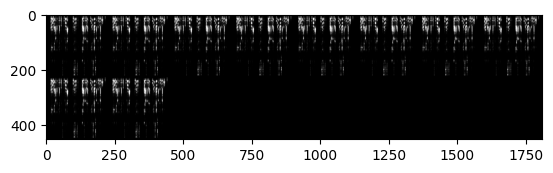

In [95]:
fleurs = FLEURSDataset()
dataloader = DataLoader(fleurs, batch_size=10, shuffle=True)
images, labels = next(iter(dataloader))

print(images.shape)
print(labels)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))

# CNN with MINDS14

'cs-CZ', 'de-DE', 'en-AU', 'en-GB', 'en-US', 'es-ES', 'fr-FR', 'it-IT', 'ko-KR', 'nl-NL', 'pl-PL', 'pt-PT', 'ru-RU', 'zh-CN', 'all'

In [ ]:
from datasets import load_dataset
minds_all = load_dataset("PolyAI/minds14", name="all", split="train")

In [ ]:
# This dataset class takes in multiple language datasets from MINDS14 and combines them for training

class MindsDataset(Dataset):
    def __init__(self, minds_array, size=(224,224), train=True, color=True):
        super(MindsDataset, self).__init__()
        self.color = color
        self.size = size
        minds_array_np = np.concatenate(minds_array)
        self.audio_files = [audio["path"] for audio in minds_array_np]
        self.transform = transforms.Compose([
            transforms.Resize((self.size[0], self.size[1])),
            ])
        self.labels = {audio["path"]: audio["lang_id"] for audio in minds_array_np}

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        label = self.labels.get(audio_path)
        waveform, sample_rate = torchaudio.load(audio_path)
        spectrogram = self.transform(torchaudio.transforms.MelSpectrogram()(waveform))

        if self.color == True:
            # grayscale to color
            spectrogram_colored = plt.cm.viridis(spectrogram)
            # normalize
            # spectrogram_colored = (spectrogram_colored - spectrogram_colored.min()) / (spectrogram_colored.max() - spectrogram_colored.min())
            # fixing dimensions and shape positions
            spectrogram = torch.Tensor(spectrogram_colored.squeeze(0))[:,:,:3].permute(2,0,1)

        return spectrogram, label

    def __len__(self):
        return len(self.audio_files)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([4, 3, 224, 224])
tensor([1, 6, 3, 6])


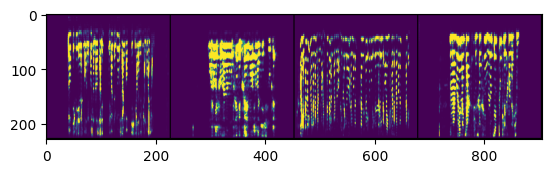

In [ ]:
batch_size = 4

minds_test_dataset = MindsDataset([minds_all])
minds_test_loader = DataLoader(minds_test_dataset, batch_size=batch_size, shuffle=True)

dataiter = iter(minds_test_loader)
images, labels = next(dataiter)

print(images.shape)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))

print(labels)

  0%|          | 0/256 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


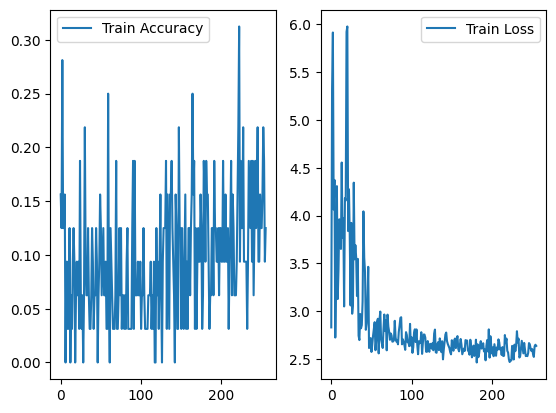

Train Accuracy: 0.13
Train Loss: 2.6044512796401977


In [ ]:
subset_percentage = 1
epochs = 1
lr = 0.01
num_classes = 14
batch_size = 32
device = torch.device('cuda:0')

minds_train_dataset = MindsDataset([minds_all])
minds_train_loader = DataLoader(minds_test_dataset, batch_size=batch_size, shuffle=True)

subset_indices = np.random.choice(len(minds_train_dataset), int(len(minds_train_dataset) * subset_percentage), replace=False)
subset_sampler = SubsetSampler(subset_indices)

train_loader = DataLoader(minds_train_dataset,
                          sampler=subset_sampler,
                          num_workers=2,
                          batch_size=batch_size,
                          pin_memory=True)

model_2 = CNN(num_classes).cuda()

objective = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_2.parameters(), lr=lr)

train_losses, train_accs, model_2 = train(model_2, train_loader, objective, optimizer, epochs, device)

# AST implementation

## Architecture


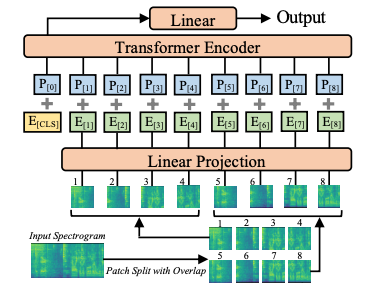

1.   input is a 128x100t spectrogram
2.   split into N 16x16 patches where $N=12((100t - 16) / 10)$
3.   flatten each 16x16 to a 1D patch embedding of size 768 w/ linear projection layer (patch embedding layer)
4.   add trainable positional embedding (size 768) to each patch embedding
5.   append CLS to beginning of sequence --> input to transformer
6.   transformer encoder (768, 12 layers, 12 heads) --> linear layer with sigmoid maps transformer output to class labels.



### Summary
1.   image --> patch embedding
2.   patch embeddings...CLS token + positional embeddings
3.   embeddings --> T encoder --> linear --> labels



Implementation credit given to: https://github.com/YuanGongND/ast/tree/master from the [AST: Audio Spectrogram Transformer paper](https://arxiv.org/pdf/2104.01778.pdf)

In [131]:
!pip install timm
import torch
from timm import create_model
import timm
from timm.models.layers import to_2tuple,trunc_normal_

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

## Model Class

In [163]:
class ASTModel(nn.Module):
    def __init__(self, vit, num_classes, fstride=10, tstride=10, fdim=128, tdim=1024):
        super(ASTModel, self).__init__()

        # using a pretrained ViT for the default transformer encoder, patch embedder and positional embedder
        self.vit = vit
        self.label_dim = num_classes

        self.original_embedding_dim = self.vit.pos_embed.shape[2]
        self.original_num_patches = self.vit.patch_embed.num_patches

        f_dim, t_dim = self.get_shape(fstride, tstride, fdim, tdim)
        num_patches = f_dim * t_dim
        self.vit.patch_embed.num_patches = num_patches

        # the linear projection layer
        new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        new_proj.weight = torch.nn.Parameter(torch.sum(self.vit.patch_embed.proj.weight, dim=1).unsqueeze(1))
        new_proj.bias = self.vit.patch_embed.proj.bias
        self.vit.patch_embed.proj = new_proj

        self.original_hw = int(self.original_num_patches ** 0.5)

        # print(self.vit.pos_embed[:, 1:, :].shape)
        # print(self.original_num_patches)
        # print(self.original_embedding_dim)
        # print(self.original_hw)
        new_pos_embedding = self.vit.pos_embed[:, 1:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.original_hw, self.original_hw)

        # "...cut and bi-linear interpolate method for positional embedding adaptation..."
        new_pos_embedding = torch.nn.functional.interpolate(new_pos_embedding, size=(12, t_dim), mode='bilinear')
        new_pos_embedding = torch.nn.functional.interpolate(new_pos_embedding, size=(f_dim, t_dim), mode='bilinear')

        # "...we add a trainable positional embedding (also of size 768) to each patch embedding..."
        new_pos_embedding = new_pos_embedding.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)

        # "We therefore cut the first dimension and interpolate the second
        # dimension of the 24 × 24 ViT positional embedding to 12 × 100 and use it as the positional embedding for the AST."
        self.vit.pos_embed = nn.Parameter(torch.cat([self.vit.pos_embed[:, :1, :].detach(), new_pos_embedding], dim=1))

        # "Finally, since the classification task is essentially different, we
        # abandon the last classification layer of the ViT and reinitialize a new one for AST."
        self.final = nn.Sequential(nn.Linear(self.original_embedding_dim, self.label_dim), nn.Sigmoid())

        print(self.vit.pos_embed.shape)


    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    def forward(self, x):
        # print(x.shape)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        # print(x.shape)

        # get patch embeddings from image
        x = self.vit.patch_embed(x)

        # get the correctly shapped CLS token (depends on image size)
        cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)

        # concat the patch embeddings and the CLS token before adding positional embeddings
        x = torch.cat((cls_token, x), dim=1)

        # add positional embeddings before passing into transformer encoder
        x = x + self.vit.pos_embed

        # pass through transformer encoder blocks
        for block in self.vit.blocks:
            x = block(x)

        # print(x.shape)

        x = self.vit.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        # print(x.shape)

        x = self.final(x)

        return x

In [ ]:
fleurs

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([4, 1, 224, 224])
tensor([ 6, 12, 11,  7])


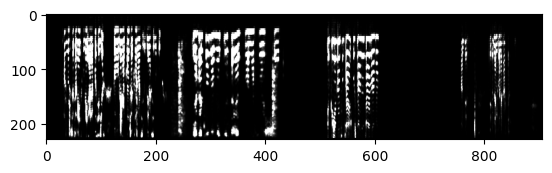

In [ ]:
batch_size = 4
# size = (128, 862)
size = (224, 224)

minds_test_dataset = MindsDataset([minds_all], size=size, color=False)
minds_test_loader = DataLoader(minds_test_dataset, batch_size=batch_size, shuffle=True)

dataiter = iter(minds_test_loader)
images, labels = next(dataiter)

print(images.shape)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))

print(labels)

### Testing input and output shapes

In [ ]:
input_tdim = 224
input_fdim = 224

vit = create_model('vit_base_patch16_224', pretrained=True)
# print(vit.pos_embed.shape)
ast = ASTModel(vit, num_classes=14, fstride=10, tstride=10, fdim=input_fdim, tdim=input_tdim)

torch.Size([1, 442, 768])


In [ ]:
test_input = torch.rand([4, 224, 224])

test_output = ast(test_input)
print(test_output.shape)

torch.Size([4, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 14])


In [ ]:
# torch image has default 1 color channel: Maybe we can pass in color images if the model is unsqueezing the color dimnension?
test_input = images.squeeze(1)
print(test_input.shape)

test_output = ast(test_input)
print(test_output.shape)

torch.Size([4, 224, 224])
torch.Size([4, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 14])


Zero-shot testing literally makes no sense because the model doens't have any idea what the 14 label dimensions mean yet.

In [ ]:
print(test_output.argmax(dim=1))
print(labels)

tensor([ 4, 12, 12,  4])
tensor([7, 7, 2, 7])


## Training AST

torch.Size([4, 224, 224])
tensor([1, 2, 2, 0])


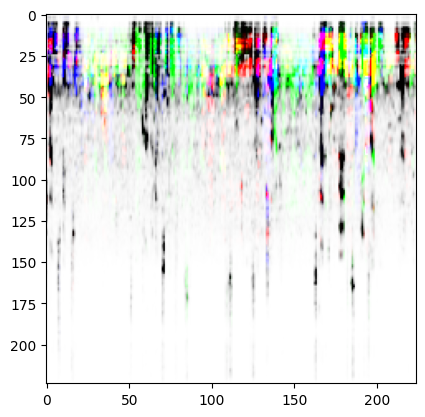

In [141]:
class AudioDatasetAST(Dataset):
    def __init__(self, path, train=True):
        super(AudioDatasetAST, self).__init__()
        self.size = 224
        self.path = path
        self.audio_files = [f for f in os.listdir(os.path.join(path)) if f.endswith('.flac')]
        self.resize = transforms.Compose([
            transforms.Resize((self.size, self.size)),
            ])

        if train:
            with open(os.path.join('train_labels.json'), 'r') as f:
                self.labels = json.load(f)
        else:
            with open(os.path.join('test_labels.json'), 'r') as f:
                self.labels = json.load(f)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        audio_path = os.path.join(self.path, audio_file)
        label = self.labels.get(audio_file)

        waveform, sample_rate = torchaudio.load(audio_path)

        spectrogram = torchaudio.transforms.MelSpectrogram(n_fft=512)(waveform)
        spectrogram_tensor = torch.from_numpy(spectrogram.numpy())

        spectrogram_tensor = self.resize(spectrogram_tensor)

        spectrogram_tensor = spectrogram_tensor.squeeze(0)

        return spectrogram_tensor, label

    def __len__(self):
        return len(self.audio_files)


batch_size = 4
train_path = 'train/train'
test_path = 'test/test'

train_dataset = AudioDatasetAST(train_path, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))

print(labels)

torch.Size([1, 442, 768])


  0%|          | 0/3654 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set to

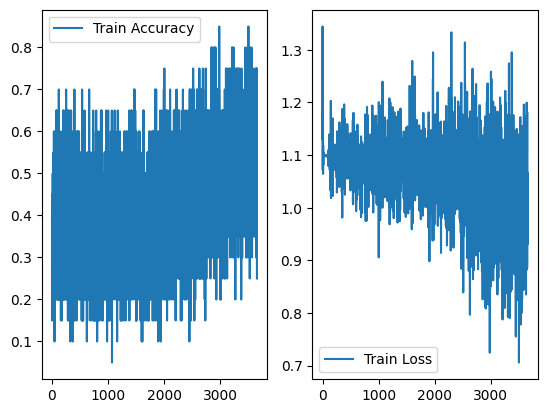

Train Accuracy: 0.5270000112056732
Train Loss: 0.9914653921127319


In [185]:
subset_percentage = 1  # Select 10% of the training dataset randomly
epochs = 1
lr = 0.0001
num_classes = 3
batch_size = 20
device = torch.device('cuda:0')
vit = create_model('vit_base_patch16_224', pretrained=True)

train_path = 'train/train'
test_path = 'test/test'

train_dataset = AudioDatasetAST(train_path, train=True)
test_dataset = AudioDatasetAST(test_path, train=False)

subset_indices = np.random.choice(len(train_dataset), int(len(train_dataset) * subset_percentage), replace=False)
subset_sampler = SubsetSampler(subset_indices)

train_loader = DataLoader(train_dataset,
                          sampler=subset_sampler,
                          num_workers=3,
                          batch_size=batch_size,
                          pin_memory=True)
test_loader = DataLoader(test_dataset,
                            shuffle=True,
                            num_workers=3,
                            batch_size=batch_size,
                            pin_memory=True)

model = ASTModel(vit, num_classes=num_classes, fstride=10, tstride=10, fdim=224, tdim=224).cuda()

objective = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

train_losses, train_accs, model = train(model, train_loader, objective, optimizer, epochs, device)

In [186]:
torch.cuda.empty_cache()
gc.collect()

10371

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


Test Accuracy: 0.4462963044643402
Test Loss: 1.055946449438731


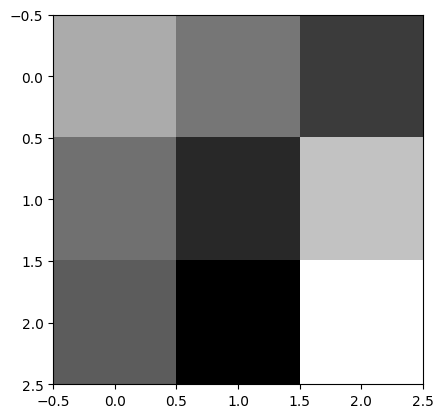

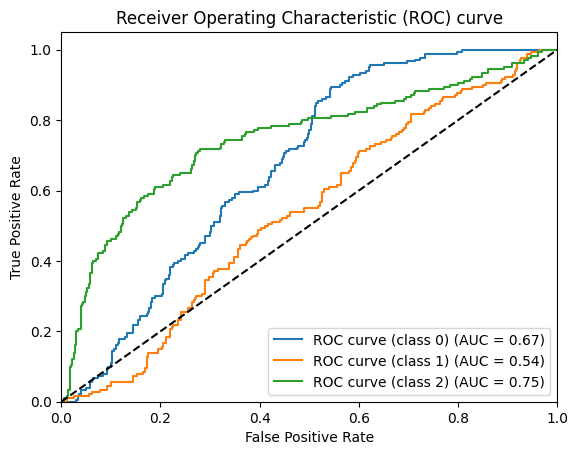

In [187]:
evaluate(model, test_loader, objective, device)

Train Accuracy: 0.537000013589859
Train Loss: 0.9890224862098694